<h1>San Diego calls for service</h1>

<h2>Table of Contents</h2>

<div>
<ol>
    <li><a href="#Business-case">Business case</a></li>
    <li><a href="#Data-description">Data description</a></li>
    <li><a href="#Descriptive-statistics">Descriptive statistics</a>
    <ol>
        <li><a href="#Crimes-per-year">Crimes per year</a></li>
        <li><a href="#Criminals-seem-to-have-weekends,-too">Criminals seem to have weekends, too</a></li>
        <li><a href="#Crimes-per-hour">Crimes per Hour</a></li>
        <li><a href="#Crimes-by-priority">Crimes by Priority</a></li>
        <li><a href="#Crimes-by-call-type">Crimes by Call Type</a></li>
        <li><a href="#Crimes-by-Police-Beats">Crimes by Police Beats</a></li>
    </ol>
    <li><a href="#Correlation-matrix">Correlation Matrix</a></li>
    <li><a href="#Bivariate-analysis">Bivariate analysis</a>
    <ol>
        <li><a href="#Crimes-vs-Temperature">Crimes vs. Temperature</a></li>
        <li><a href="#Crimes-vs-Day-of-the-Month">Crimes vs. Day of the Month</a></li>
        <li><a href="#Crimes-vs-Holidays">Crimes vs. Holidays</a></li>
    </ol>
    <li><a href="#Visualize-with-map">Visualize with Map</a></li>
    <li><a href="#Data-Preprocessing">Data Preprocessing</a>
    <ol>
        <li><a href="#Create-Dummy-Variables">Create Dummy Variables</a></li>
        <li><a href="#Create-Test-and-Training-Set">Create Test and Training Set</a></li>
    </ol>
    <li><a href="#Regression-Analysis">Regression Analysis</a>
    <ol>
        <li><a href="#Decision-Trees">Decision Trees</a></li>
        <li><a href="#Random-Forest-Regression">Random Forest Regression</a></li>
        <li><a href="#Gradient-Boosting-Regression">Gradient Boosting Regression</a></li>
        <li><a href="#XGBoost">XGBoost</a></li>
        <li><a href="#Comparison">Comparison</a></li>
    </ol>
</ol>
</div>

<h2>Business case</h2>

The goal of our analysis is to predict crimes in the wonderful city of San Diego, CA.<br>


<h2>Data description</h2>

We will use data from different sources. Some of them are public and some are private:<br>
<ol>
    <li><a href="https://data.sandiego.gov/datasets/police-calls-for-service/">Police Calls for Service</a> by the City of San Diego</li>
    <li><a href="https://data.sandiego.gov/datasets/police-beats/">San Diego Police Department beats</a> by the City of San Diego</li>
    <li><a href="https://data.sandiego.gov/datasets/pd-neighborhoods/">San Diego Police neighborhoods</a> by the City of San Diego</li>
    <li><a href="https://data.sandiego.gov/datasets/police-calls-call-types/">Police Calls for Service Call Types</a> by the City of San Diego</li>
    <li><a href="https://home.openweathermap.org/">Weather data for San Diego</a> by Openweather (no free usage)</li>
</ol>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gpd
import seaborn as sns
import branca.colormap as cm
import matplotlib.pyplot as plt
import folium
import os
import warnings
import pickle
import holidays
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from xgboost import XGBRegressor
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df = pd.DataFrame(columns=[
    'incident_num', 'date_time', 'day_of_week', 'address_number_primary', 'address_dir_primary', 'address_road_primary', 'address_sfx_primary',
    'address_dir_intersecting', 'address_road_intersecting', 'address_sfx_intersecting', 'call_type', 'disposition', 'beat', 'priority'
                          ]
                 )

The type of police calls changed in time. So we need to join a current and a historical version.

In [3]:
df_call_types_hist = pd.read_csv('Call types/pd_cfs_calltypes_historical_data_20171017.csv')
df_call_types = pd.read_csv('Call types/pd_cfs_calltypes_datasd.csv')

In [4]:
for dataset in os.listdir('Police Calls'):
    if 'dictionary' not in dataset and 'Original' not in dataset: 
        # Load file with police calls
        df_h = pd.read_csv('Police Calls/' + dataset, sep=';')
        # Change date to datetime
        df_h['date_time'] = pd.to_datetime(df_h['date_time'])
        # Calculate day of week to be consistent
        df_h['day_of_week'] = df_h['date_time'].dt.dayofweek
        df_h = df_h.dropna(subset=['beat'])      
        df_h.beat = df_h.beat.astype(int)
        df = pd.concat([df, df_h])
df = df.reset_index(drop=True)
df = df.dropna(subset=['beat'])

In [5]:
df_1 = df[df['date_time'] < '2017-10-17 00:00:00']
df_2 = df[df['date_time'] > '2017-10-17 00:00:00']

In [6]:
# Check if we missed columns
len(df_1) + len(df_2) == len(df)

True

In [7]:
# Join different DFs
df_1 = df_1.join(df_call_types_hist.set_index('call_type'), on='call_type')
df_2 = df_2.join(df_call_types.set_index('call_type'), on='call_type')
df = pd.concat([df_1, df_2])
# Read beats and join to know neighbourhood
df_beats = pd.read_csv('Beats/pd_beat_codes_list_datasd.csv').set_index('beat')
df = df.join(df_beats, on='beat').dropna(subset=['neighborhood'])

In [8]:
df['priority'] = df.priority.astype(str).replace('1.0', '1').replace('2.0', '2').replace('3.0', '3').replace('4.0', '4')
df = df[df['priority'].isin(['E', '1', '2', '3', '4'])]

In [9]:
df.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority,description,neighborhood
0,P15010000001,2015-01-01 00:00:00,3,3800,NaN,DELTA,ST,NaN,NaN,NaN,AU1,K,443,1,ALL UNITS INFORMATION-PRI 1,Shelltown
1,P15010000002,2015-01-01 00:00:00,3,0,NaN,60TH,ST,NaN,FEDERAL,BL,AU1,DUP,433,1,ALL UNITS INFORMATION-PRI 1,Encanto
2,P15010000003,2015-01-01 00:00:00,3,3600,NaN,LOGAN,AV,NaN,NaN,NaN,AU1,DUP,441,1,ALL UNITS INFORMATION-PRI 1,Mountain View
3,P15010000004,2015-01-01 00:00:00,3,0,NaN,33RD,ST,NaN,IMPERIAL,AV,AU1,K,512,1,ALL UNITS INFORMATION-PRI 1,Logan Heights
4,P15010000005,2015-01-01 00:01:00,3,3300,NaN,43RD,ST,NaN,NaN,NaN,AU1,O,834,1,ALL UNITS INFORMATION-PRI 1,Castle


In [10]:
df['date'] = pd.DatetimeIndex(df.date_time).normalize()
df['weekday'] = df['date_time'].dt.day_name()

In [11]:
# Add windspeed, visibillity, precipitation
df_weather = pd.read_csv('Weather/weather_san_diego.csv')
df_weather.dt = pd.to_datetime(df_weather.dt,unit='s')
df_weather = df_weather[['dt', 'temp', 'weather_main', 'humidity', 'wind_speed']]
df_weather.temp = df_weather.temp.subtract(273,15)
df_weather = df_weather.set_index('dt')

df_weather_grouped = df_weather.loc[df_weather.groupby(pd.Grouper(freq='D')).idxmax().iloc[:, 0]]
df_weather_grouped.index = pd.DatetimeIndex(df_weather_grouped.index).normalize()

In [12]:
df_weather_grouped.head()

,temp,weather_main,humidity,wind_speed
dt,,,,
1979-01-01,17.64,Clouds,21,4.6
1979-01-02,17.45,Clouds,26,3.1
1979-01-03,18.27,Clouds,23,4.1
1979-01-04,17.44,Clouds,30,3.1
1979-01-05,16.74,Clouds,77,9.3


In [13]:
df = df.set_index('date', drop=False).join(df_weather_grouped)
df = df.rename(columns={'neighborhood': 'district'})
df.district = df.district.str.upper()
df['temp'] = round(df['temp'], 1)

In [14]:
us_holidays = holidays.CountryHoliday('US', prov=None, state='CA')
for year in range(2015, 2020):
    dt.date(year, 1, 1) in us_holidays
    
cali_holidays = pd.DataFrame(us_holidays.keys()).rename(columns={0: 'date'})
cali_holidays['holiday'] = 1
cali_holidays = cali_holidays.set_index('date')

In [15]:
df = df.join(cali_holidays).fillna(value={'holiday': 0})

In [16]:
df.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,...,priority,description,district,date,weekday,temp,weather_main,humidity,wind_speed,holiday
2015-01-01,P15010000001,2015-01-01 00:00:00,3,3800,NaN,DELTA,ST,NaN,NaN,NaN,...,1,ALL UNITS INFORMATION-PRI 1,SHELLTOWN,2015-01-01,Thursday,14.4,Clouds,33,3.1,1.0
2015-01-01,P15010000002,2015-01-01 00:00:00,3,0,NaN,60TH,ST,NaN,FEDERAL,BL,...,1,ALL UNITS INFORMATION-PRI 1,ENCANTO,2015-01-01,Thursday,14.4,Clouds,33,3.1,1.0
2015-01-01,P15010000003,2015-01-01 00:00:00,3,3600,NaN,LOGAN,AV,NaN,NaN,NaN,...,1,ALL UNITS INFORMATION-PRI 1,MOUNTAIN VIEW,2015-01-01,Thursday,14.4,Clouds,33,3.1,1.0
2015-01-01,P15010000004,2015-01-01 00:00:00,3,0,NaN,33RD,ST,NaN,IMPERIAL,AV,...,1,ALL UNITS INFORMATION-PRI 1,LOGAN HEIGHTS,2015-01-01,Thursday,14.4,Clouds,33,3.1,1.0
2015-01-01,P15010000005,2015-01-01 00:01:00,3,3300,NaN,43RD,ST,NaN,NaN,NaN,...,1,ALL UNITS INFORMATION-PRI 1,CASTLE,2015-01-01,Thursday,14.4,Clouds,33,3.1,1.0


<h2>Descriptive statistics</h2>

<h3>Crimes per year</h3>

In the following...

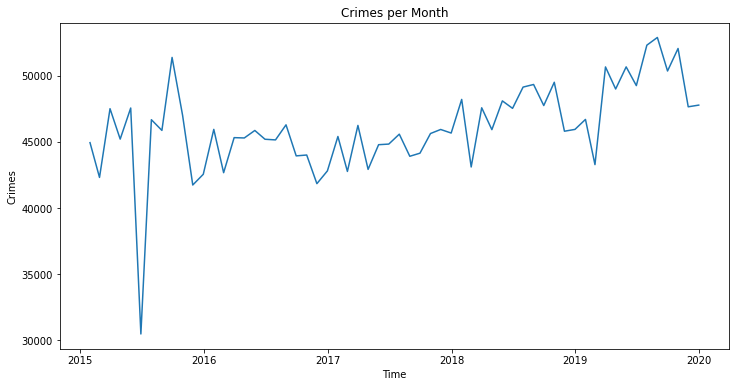

In [17]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df['day_of_week'].resample('M').count().index, y=df['day_of_week'].resample('M').count().values)
plt.ylabel('Crimes')
plt.xlabel('Time')
plt.title('Crimes per Month')
plt.show()

<h3>Criminals seem to have weekends, too</h3>

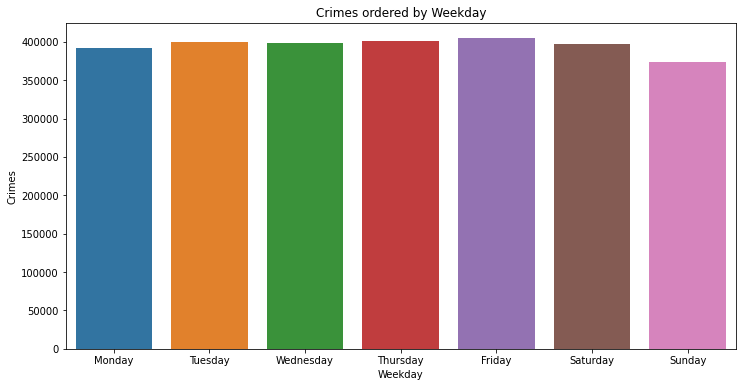

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(x='weekday', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Crimes ordered by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Crimes')
plt.show()

<h3>Crimes per hour</h3>

And they have a lunch break, too...

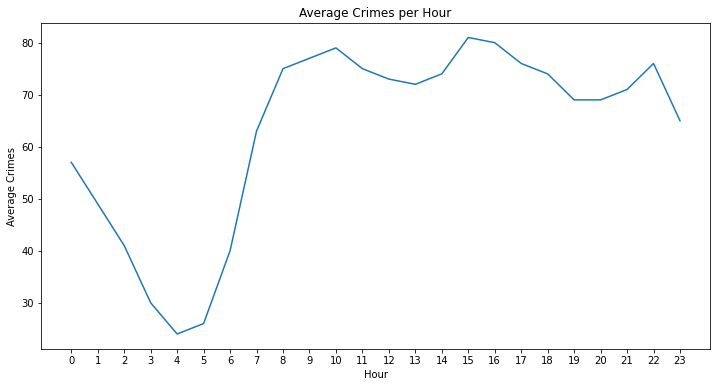

In [19]:
plt.figure(figsize=(12, 6))
crimes_per_hour = df.set_index('date_time')['weekday'].resample('H').count()
hours = [x for x in range(0, 24)]
crimes_per_hour = round(crimes_per_hour.groupby(crimes_per_hour.index.hour).mean(), 0)
sns.lineplot(x=hours, y=crimes_per_hour.values)
plt.xlabel('Hour')
plt.ylabel('Average Crimes')
plt.title('Average Crimes per Hour')
plt.xticks(hours, hours)
plt.show()

<h3>Crimes by priority</h3>

The San Diego Police Department differs service calls in five priorities:
* Priority E: Dispatch Immediately. Priority E calls involve an imminent threat to life.
* Priority One: Dispatch Immediately. Priority One calls involve serious crimes in progress and those in which there is a threat to life. 
* Priority Two: Dispatch as quickly as possible.
* Priority Three: Dispatch as quickly as possible after higher priority calls.
* Priority Four: Dispatch when no higher priority calls for the beat are waiting to be assigned.

*Source: <a href=http://seshat.datasd.org/pd/pd_cfs_priority_defs_datasd.pdf>Priority Definitions</a>*

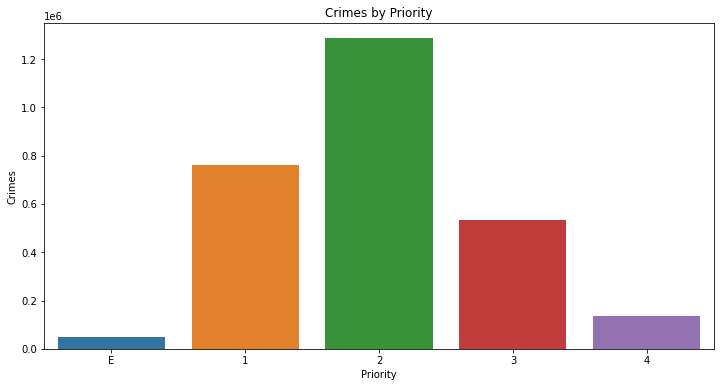

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(x='priority', data=df, order=['E', '1', '2', '3', '4'])
plt.title('Crimes by Priority')
plt.ylabel('Crimes')
plt.xlabel('Priority')
plt.show()

<h3>Crimes by call type</h3>

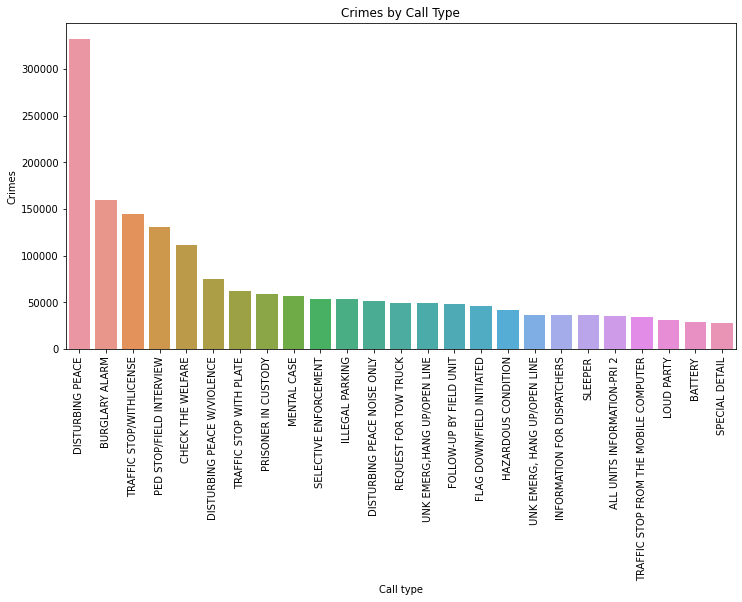

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(x='description', data=df, order=df['description'].value_counts().iloc[:25].index)
plt.title('Crimes by Call Type')
plt.ylabel('Crimes')
plt.xlabel('Call type')
plt.xticks(rotation=90)
plt.show()

<h3>Crimes by Police Beats</h3>

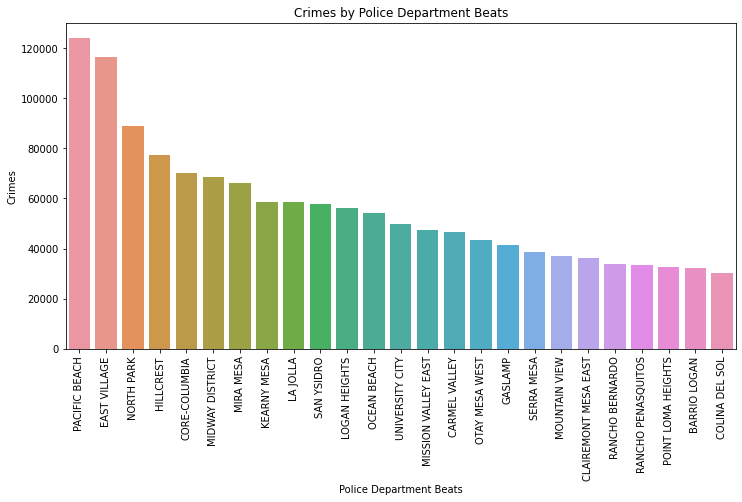

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(x='district', data=df, order=df['district'].value_counts().iloc[:25].index)
plt.xlabel('Police Department Beats')
plt.ylabel('Crimes')
plt.title('Crimes by Police Department Beats')
plt.xticks(rotation=90)
plt.show()

<h2>Correlation matrix</h2>

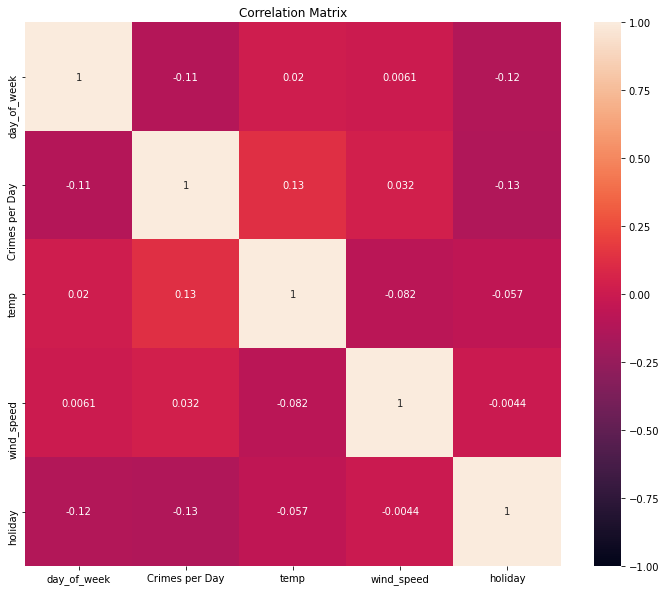

In [23]:
plt.figure(figsize=(12, 10))
corr_map_df = df.resample('D').agg({'day_of_week': 'max', 'district': 'count', 'date': 'count', 'temp': 'mean', 'wind_speed': 'mean', 'weekday': 'max', 'holiday': 'max'})[['day_of_week', 'district', 'temp', 'wind_speed', 'weekday', 'holiday']].dropna()
corr_map_df.rename(columns={'district':'Crimes per Day'}, inplace=True)
sns.heatmap(corr_map_df.corr(), annot=True, vmin=-1, vmax=1, )
plt.title('Correlation Matrix')
plt.show()

<h2>Bivariate analysis</h2>

<h3>Crimes vs Temperature</h3>

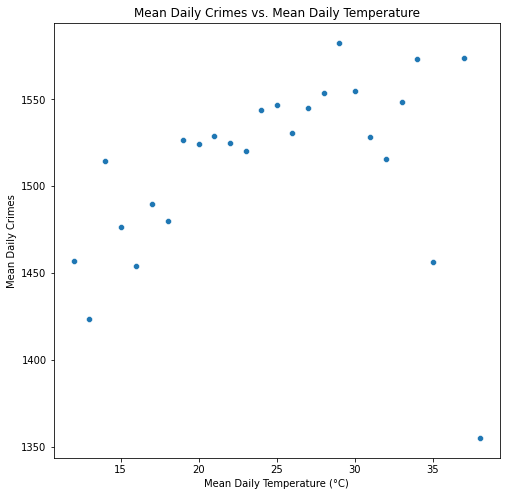

In [24]:
df_temp = pd.DataFrame()
df_temp['temp'] = round(df['temp'])
df_temp['district'] = df['district']
plt.figure(figsize=(8, 8))
crimes_vs_weather = df_temp.resample('D').agg({'temp':'mean', 'district':'count'}).dropna().groupby(by='temp').mean()
sns.scatterplot(x=crimes_vs_weather.index, y=crimes_vs_weather['district'])
plt.title('Mean Daily Crimes vs. Mean Daily Temperature')
plt.ylabel('Mean Daily Crimes')
plt.xlabel('Mean Daily Temperature (°C)')
plt.show()

<h3>Crimes vs Day of the Month</h3>

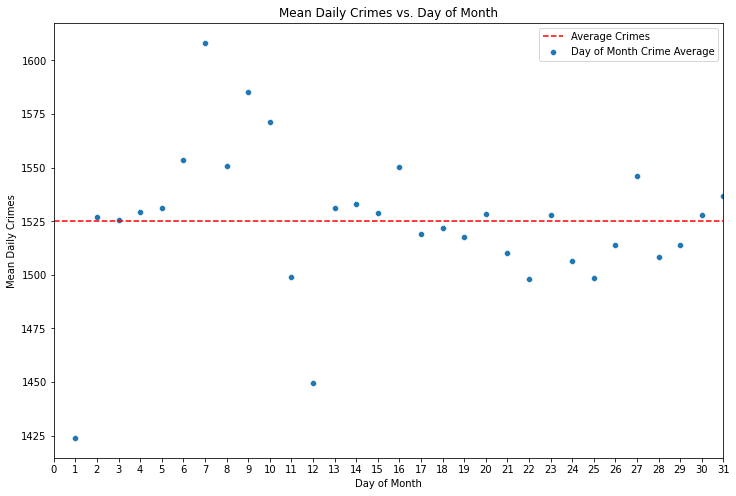

In [25]:
df_crimes_month = df.copy()
df_crimes_month['Day'] = df_crimes_month.index.day
df_crimes_month = df_crimes_month.resample('D').agg({'Day':'mean', 'district':'count'}).dropna().groupby(by='Day').mean()
avg_crimes = df_crimes_month['district'].mean()

plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_crimes_month.index, y=df_crimes_month['district'])
plt.title('Mean Daily Crimes vs. Day of Month')
plt.ylabel('Mean Daily Crimes')
plt.xlabel('Day of Month')
plt.xlim((1,31))
plt.xticks(ticks=[x for x in range(0, 32)])
plt.axhline(avg_crimes, ls='--', color='red')
plt.legend(['Average Crimes', 'Day of Month Crime Average'])
plt.show()

<h3>Crimes vs Holidays</h3>

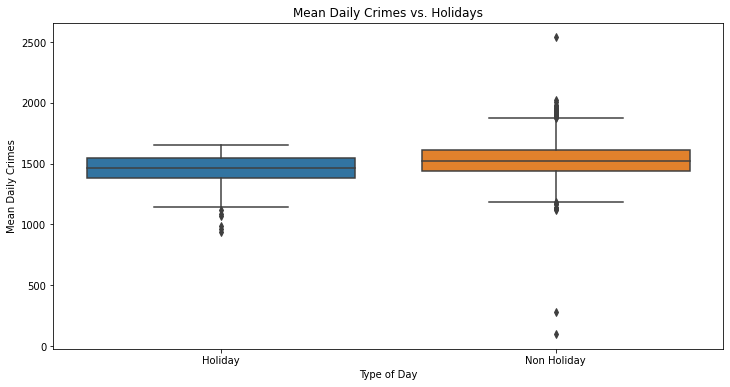

In [26]:
df_holiday = df.resample('D').agg({'holiday':'max', 'district':'count'}).rename(columns={'district': 'Crimes'}).dropna()
df_holiday['holiday'] = df_holiday['holiday'].astype(str).str.replace('1.0', 'Holiday').replace('0.0', 'Non Holiday')

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='holiday', y='Crimes', data=df_holiday)
plt.title('Mean Daily Crimes vs. Holidays')
plt.ylabel('Mean Daily Crimes')
plt.xlabel('Type of Day')
plt.show()

<h2>Visualize with Map</h2>

In [27]:
crimes_aggr = df[['date_time', 'district']].groupby(by=["district"]).agg("count").rename(columns={'date_time': 'number_of_crimes'}).reset_index(drop=False)

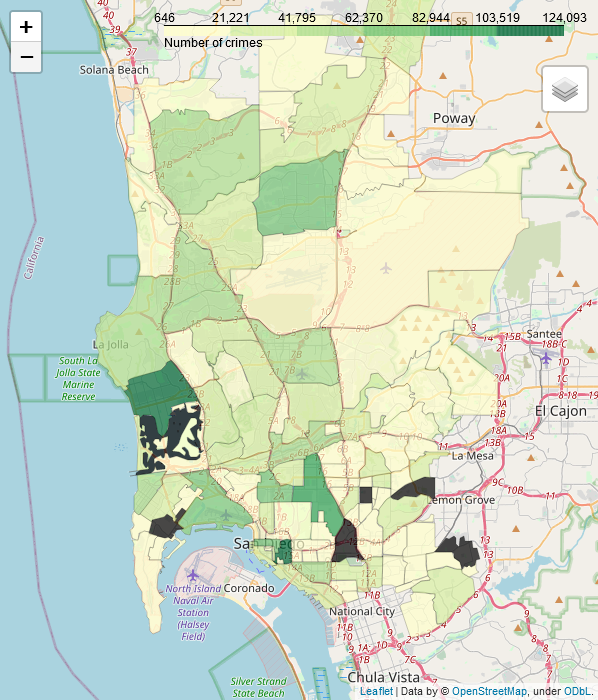

In [28]:
f = folium.Figure(width=600, height=700)
m = folium.Map(location=[32.828924, -117.142415], zoom_start=11).add_to(f)

choropleth = folium.Choropleth(
    geo_data='pd_neighborhoods_datasd.geojson',
    name='choropleth',
    data=crimes_aggr,
    columns=['district', 'number_of_crimes'],
    key_on='properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of crimes',
    highlight=True,
).add_to(m)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['name'],labels=False)).add_to(m)

folium.LayerControl().add_to(m)

m

In [29]:
# Colormap
colormap = cm.LinearColormap(colors=['green','red'], vmin=crimes_aggr['number_of_crimes'].min(), vmax=crimes_aggr['number_of_crimes'].max())

sd_neighbourhoods = gpd.read_file("pd_neighborhoods_datasd.geojson")
df_map = sd_neighbourhoods.merge(crimes_aggr.rename(columns={'district': 'name'}), on="name")

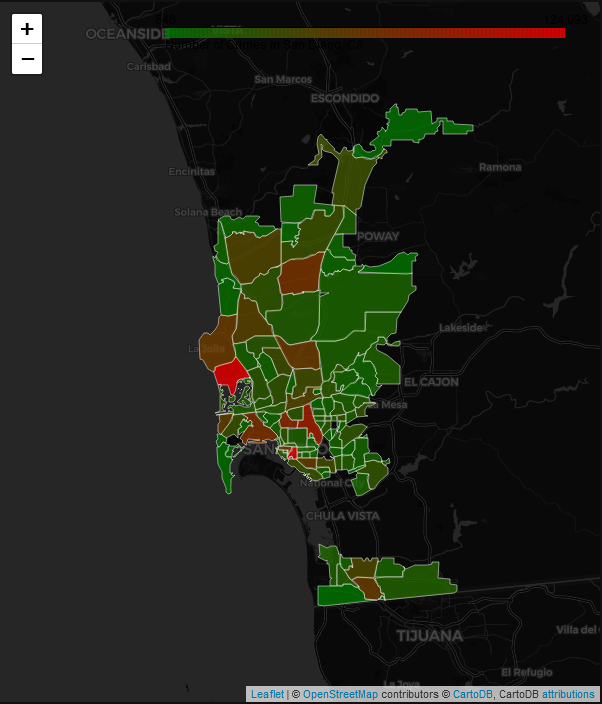

In [30]:
# Schrift weiß
f = folium.Figure(width=800, height=900)
colormap.caption = 'Number of Crimes in San Diego, CA'
san_diego_map = folium.Map(location=[32.828924, -117.142415], zoom_start=10, tiles=None).add_to(f)
folium.TileLayer('cartodbdark_matter', name='Dark Map', control=False).add_to(san_diego_map)
style_function = lambda x: {'weight': 0.5, 'color': 'white', 'fillColor': colormap(x['properties']['number_of_crimes']), 'fillOpacity': 0.75}
highlight_function = lambda x: {'fillColor': '#000000', 'color': '#000000', 'fillOpacity': 0.50, 'weight': 0.1}
info=folium.features.GeoJson(
    df_map, 
    style_function=style_function, 
    control=False, 
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'number_of_crimes'], 
        aliases=['District: ', 'Number of Crimes'],
        sticky=True
        )
    )
colormap.add_to(san_diego_map)
san_diego_map.add_child(info)
san_diego_map

In [31]:
df = df.drop(['date_time'], axis=1)
df = df.groupby([pd.Grouper(freq='1D'), 'district']).agg({'day_of_week':'first', 'district':'count', 'temp':'mean', 'wind_speed': 'mean'}).dropna()
df['year'] = df.index.get_level_values(0).year
df['month'] = df.index.get_level_values(0).month
df['day'] = df.index.get_level_values(0).day
df = df.rename(columns={'district': 'crimes'})

In [32]:
df.head()

day_of_week  crimes  temp  wind_speed  year  \
           district                                                             
2015-01-01 ADAMS NORTH                      3       4  14.4         3.1  2015   
           ALLIED GARDENS                   3       9  14.4         3.1  2015   
           AZALEA/HOLLYWOOD PARK            3       3  14.4         3.1  2015   
           BALBOA PARK                      3       4  14.4         3.1  2015   
           BARRIO LOGAN                     3      16  14.4         3.1  2015   

                                  month  day  
           district                           
2015-01-01 ADAMS NORTH                1    1  
           ALLIED GARDENS             1    1  
           AZALEA/HOLLYWOOD PARK      1    1  
           BALBOA PARK                1    1  
           BARRIO LOGAN               1    1

<h2>Data Preprocessing</h2>

<h3>Create Dummy Variables</h3>

In [33]:
data = df.reset_index(drop=False).drop(['level_0'], axis=1)
data = pd.get_dummies(data, columns=['district', 'day_of_week'], drop_first=True)
data = data.rename(columns={'day_of_week_1': 'monday', 'day_of_week_2': 'tuesday', 'day_of_week_3': 'wednesday', 'day_of_week_4': 'thursday', 'day_of_week_5': 'friday', 'day_of_week_6': 'saturday', 'day_of_week_7': 'sunday'})

<h3>Create Test and Training Set</h3>

In [34]:
X = data.drop(columns=['crimes'])
y = data['crimes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (173039, 135)
Training Labels Shape: (43260, 135)
Testing Features Shape: (173039,)
Testing Labels Shape: (43260,)


<h2>Regression Analysis</h2>

<h3>Decision Trees</h3>

In [35]:
dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [36]:
dt_score = dt.score(X_test, y_test)
dt_mse = mean_squared_error(y_test, dt.predict(X_test))

print('Decision Tree R2: ' + str(dt_score))
print('Decision Tree MSE: ' + str(dt_mse))

Decision Tree R2: 0.7022755183784527
Decision Tree MSE: 47.90238095238095


<h3>Random Forest Regression</h3>

In [37]:
rf = ensemble.RandomForestRegressor(n_estimators=1000, random_state=1)
rf.fit(X_train, y_train);

In [38]:
rf_score = rf.score(X_test, y_test)
rf_mse = mean_squared_error(y_test, rf.predict(X_test))

print('Random Forest R2: ' + str(rf_score))
print('Random Forest MSE: ' + str(rf_mse))

Random Forest R2: 0.8444481076983754
Random Forest MSE: 25.027521963638467


<h3>Gradient Boosting Regression</h3>

In [39]:
gd_reg = ensemble.GradientBoostingRegressor(n_estimators=1000, random_state=1, max_depth=10)
gd_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [40]:
gd_reg_score = gd_reg.score(X_test, y_test)
gd_reg_mse = mean_squared_error(y_test, gd_reg.predict(X_test))

print('Gradient Boosting R2: ' + str(gd_reg_score))
print('Gradient Boosting MSE: ' + str(gd_reg_mse))

Gradient Boosting R2: 0.8395866479690626
Gradient Boosting MSE: 25.80970653465479


<h3>XGBoost</h3>

In [41]:
xgb = XGBRegressor(n_estimators=1000, random_state=1, max_depth=10)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [42]:
xgb_score = xgb.score(X_test, y_test)
xgb_mse = mean_squared_error(y_test, xgb.predict(X_test))

print('XGBoost R2: ' + str(xgb_score))
print('XGBoost MSE: ' + str(xgb_mse))

XGBoost R2: 0.8237778684096829
XGBoost MSE: 28.35326014744849


<h3>Comparison</h3>

In [43]:
dt_list = [dt_score, dt_mse]
rf_list = [rf_score, rf_mse]
gd_reg_list = [gd_reg_score, gd_reg_mse]
xgb_list = [xgb_score, xgb_mse]
index = ['R2', 'MSE']
df_comparison_data = {'Decision Tree': dt_list, 'Random Forest': rf_list, 'Gradient Boosting': gd_reg_list, 'XGBoost': xgb_list, 'index': index}
df_comparison = pd.DataFrame.from_dict(df_comparison_data).set_index('index')

In [44]:
df_comparison

,Decision Tree,Random Forest,Gradient Boosting,XGBoost
index,,,,
R2,0.702276,0.844448,0.839587,0.823778
MSE,47.902381,25.027522,25.809707,28.353260


<hr>